In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.trial import Trial
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import pandas as pd
import time
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Criando dicionário de args

In [111]:
args = {
    'epoch_num': 100,    
    'lr': 2e-3,         
    'weight_decay': 0.02, 
    'batch_size': 16,    
}

# Verificando se o dispositivo é compatível com CUDA


In [112]:
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(f'Dispositivo disponível: {args["device"]}')


Dispositivo disponível: cuda


# Carregar os dados de treino e teste

In [113]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# Fazendo o mesmo pré-processamento que foi feito no notebook 01_main.ipynb


## Para o treinamento

### Coluna Cabin


In [114]:
option = 1

if option == 1:
    train_data_processed = train_data.drop(columns=['Cabin'])
    print("\nOpção 1: Coluna 'Cabin' foi removida.")

elif option == 2:
    train_data_processed = train_data.copy()
    train_data_processed['Cabin'] = train_data_processed['Cabin'].fillna('Unknown')
    print("\nOpção 2: Valores ausentes preenchidos com 'Unknown'.")

elif option == 3:
    train_data_processed = train_data.copy()
    train_data_processed.drop(columns=['Cabin'], inplace=True)
    train_data_processed['Has_Cabin'] = train_data['Cabin'].notnull().astype(int)
    print("\nOpção 3: Coluna 'Has_Cabin' criada para indicar presença de cabine.")

elif option == 4:
    train_data_processed = train_data.dropna(subset=['Cabin'])
    print(f"\nOpção 4: Linhas com valores ausentes removidas. Restam {len(train_data_processed)} linhas.")
    
else:
    print("Opção inválida. Escolha entre 1, 2, 3 ou 4.")
    train_data_processed = None

print(tabulate(train_data_processed.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(train_data_processed.isnull().sum())


Opção 1: Coluna 'Cabin' foi removida.
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|    |   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Embarked   |
+====+===============+============+==========+=====================================================+========+=======+=========+=========+==================+=========+============+
|  0 |             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |  7.25   | S          |
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|  1 |             2 |          1 |        1 | Cumings, Mrs. 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

### Coluna Age

In [115]:
option_age = 3

mean_age = None

if option_age == 1:
    data_age_processed = train_data_processed.drop(columns=['Age'])
    print("\nOpção 1: Coluna 'Age' foi removida.")

elif option_age == 2:
    data_age_processed = train_data_processed.copy()
    median_age = train_data_processed['Age'].median()
    data_age_processed['Age'] = data_age_processed['Age'].fillna(median_age)
    print(f"\nOpção 2: Valores ausentes preenchidos com a mediana ({median_age}).")

elif option_age == 3:
    data_age_processed = train_data_processed.copy()
    mean_age = train_data_processed['Age'].mean()
    data_age_processed['Age'] = data_age_processed['Age'].fillna(mean_age)
    print(f"\nOpção 3: Valores ausentes preenchidos com a média ({mean_age:.2f}).")

elif option_age == 4:
    data_age_processed = train_data_processed.dropna(subset=['Age'])
    print(f"\nOpção 4: Linhas com valores ausentes removidas. Restam {len(data_age_processed)} linhas.")

else:
    print("Opção inválida. Escolha entre 1, 2, 3 ou 4.")
    data_age_processed = None

print(tabulate(data_age_processed.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(data_age_processed.isnull().sum())


Opção 3: Valores ausentes preenchidos com a média (29.70).
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|    |   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Embarked   |
+====+===============+============+==========+=====================================================+========+=======+=========+=========+==================+=========+============+
|  0 |             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |  7.25   | S          |
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|  1 |             2 |          1 |     

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

### Coluna Embarked


In [116]:
data_embarked_processed = data_age_processed.dropna(subset=['Embarked'])

processed_data = data_embarked_processed

print(tabulate(processed_data.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(processed_data.isnull().sum())

+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|    |   PassengerId |   Survived |   Pclass | Name                                                | Sex    |   Age |   SibSp |   Parch | Ticket           |    Fare | Embarked   |
+====+===============+============+==========+=====================================================+========+=======+=========+=========+==================+=========+============+
|  0 |             1 |          0 |        3 | Braund, Mr. Owen Harris                             | male   |    22 |       1 |       0 | A/5 21171        |  7.25   | S          |
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+------------+
|  1 |             2 |          1 |        1 | Cumings, Mrs. John Bradley (Florence Briggs Thayer) |

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Para o teste


In [117]:
print("\nValores Ausentes:")
display(test_data.isnull().sum())


Valores Ausentes:


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Coluna Age


In [118]:
option_age_test = 3

if option_age_test == 1:
    test_data_processed = test_data.drop(columns=['Age'])
    print("\nOpção 1: Coluna 'Age' foi removida.")

elif option_age_test == 2:
    test_data_processed = test_data.copy()
    median_age = test_data_processed['Age'].median()
    test_data_processed['Age'] = test_data_processed['Age'].fillna(median_age)
    print(f"\nOpção 2: Valores ausentes preenchidos com a mediana ({median_age}).")

elif option_age_test == 3:
    test_data_processed = test_data.copy()
    test_data_processed['Age'] = test_data_processed['Age'].fillna(mean_age)
    print(f"\nOpção 3: Valores ausentes preenchidos com a média do treino ({mean_age:.2f}).")

else:
    print("Opção inválida. Escolha entre 1, 2 ou 3.")
    test_data_processed = None

print(tabulate(test_data_processed.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(test_data_processed.isnull().sum())


Opção 3: Valores ausentes preenchidos com a média do treino (29.70).
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+---------+------------+
|    |   PassengerId |   Pclass | Name                                         | Sex    |   Age |   SibSp |   Parch |   Ticket |    Fare |   Cabin | Embarked   |
+====+===============+==========+==============================================+========+=======+=========+=========+==========+=========+=========+============+
|  0 |           892 |        3 | Kelly, Mr. James                             | male   |  34.5 |       0 |       0 |   330911 |  7.8292 |     nan | Q          |
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+---------+------------+
|  1 |           893 |        3 | Wilkes, Mrs. James (Ellen Needs)             | female |  47   |       1 |       0 |   

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Coluna Cabin

In [119]:
option_cabin_test = 1

if option_cabin_test == 1:
    test_data_processed = test_data_processed.drop(columns=['Cabin'])
    print("\nOpção 1: Coluna 'Cabin' foi removida.")

elif option_cabin_test == 2:
    test_data_processed = test_data_processed.copy()
    test_data_processed.drop(columns=['Cabin'], inplace=True)
    test_data_processed['Has_Cabin'] = test_data['Cabin'].notnull().astype(int)
    print("\nOpção 3: Coluna 'Has_Cabin' criada para indicar presença de cabine.")
    
else:
    print("Opção inválida. Escolha entre 1 e 2")
    test_data_processed = None

print(tabulate(test_data_processed.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(test_data_processed.isnull().sum())


Opção 1: Coluna 'Cabin' foi removida.
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+------------+
|    |   PassengerId |   Pclass | Name                                         | Sex    |   Age |   SibSp |   Parch |   Ticket |    Fare | Embarked   |
+====+===============+==========+==============================================+========+=======+=========+=========+==========+=========+============+
|  0 |           892 |        3 | Kelly, Mr. James                             | male   |  34.5 |       0 |       0 |   330911 |  7.8292 | Q          |
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+------------+
|  1 |           893 |        3 | Wilkes, Mrs. James (Ellen Needs)             | female |  47   |       1 |       0 |   363272 |  7      | S          |
+----+---------------+----------+----------------

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

 ### Tratamento da coluna Fare: Preenchimento do valor ausente com a média devido ao conjunto de teste

In [120]:
media_fare = test_data_processed['Fare'].mean()
test_data_processed['Fare'] = test_data_processed['Fare'].fillna(media_fare)
print(f"\nValores ausentes em 'Fare' preenchidos com a média ({media_fare:.2f})")

print(tabulate(test_data_processed.head(), headers='keys', showindex=True, tablefmt='grid'))

print("\nValores ausentes após o tratamento:")
display(test_data_processed.isnull().sum())


Valores ausentes em 'Fare' preenchidos com a média (35.63)
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+------------+
|    |   PassengerId |   Pclass | Name                                         | Sex    |   Age |   SibSp |   Parch |   Ticket |    Fare | Embarked   |
+====+===============+==========+==============================================+========+=======+=========+=========+==========+=========+============+
|  0 |           892 |        3 | Kelly, Mr. James                             | male   |  34.5 |       0 |       0 |   330911 |  7.8292 | Q          |
+----+---------------+----------+----------------------------------------------+--------+-------+---------+---------+----------+---------+------------+
|  1 |           893 |        3 | Wilkes, Mrs. James (Ellen Needs)             | female |  47   |       1 |       0 |   363272 |  7      | S          |
+----+---------------+------

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

# Deep Learning

## Antes de tudo, vamos realizar o encoding das colunas categóricas e a normalização dos dados


In [121]:
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
scaler = StandardScaler()

le_sex.fit(processed_data['Sex'])
le_embarked.fit(processed_data['Embarked'])

numeric_columns = ['Age', 'Fare', 'SibSp', 'Parch']
scaler.fit(processed_data[numeric_columns])

def prepare_data_for_nn(data, is_training=True):

    processed_data = data.copy()
    
    columns_to_drop = ['PassengerId', 'Name', 'Ticket']
    processed_data = processed_data.drop(columns=columns_to_drop, errors='ignore')
    
    processed_data['Sex'] = le_sex.transform(processed_data['Sex']).astype('float32')
    processed_data['Embarked'] = le_embarked.transform(processed_data['Embarked']).astype('float32')
    
    numeric_columns = ['Age', 'Fare', 'SibSp', 'Parch']
    processed_data[numeric_columns] = scaler.transform(processed_data[numeric_columns]).astype('float32')
    
    if 'Pclass' in processed_data.columns:
        processed_data['Pclass'] = processed_data['Pclass'].astype('float32')
    if 'Has_Cabin' in processed_data.columns:
        processed_data['Has_Cabin'] = processed_data['Has_Cabin'].astype('float32')
    if 'Survived' in processed_data.columns:
        processed_data['Survived'] = processed_data['Survived'].astype('float32')
    
    output_file = '../data/train_processed.csv' if is_training else '../data/test_processed.csv'
    processed_data.to_csv(output_file, index=False)
    print(f"\nDados processados salvos em: {output_file}")
    print("\nPrimeiras linhas dos dados processados:")
    print(tabulate(processed_data.head(), headers='keys', tablefmt='grid'))

In [122]:
prepare_data_for_nn(processed_data, is_training=True)


Dados processados salvos em: ../data/train_processed.csv

Primeiras linhas dos dados processados:
+----+------------+----------+-------+-----------+-----------+-----------+-----------+------------+
|    |   Survived |   Pclass |   Sex |       Age |     SibSp |     Parch |      Fare |   Embarked |
+====+============+==========+=======+===========+===========+===========+===========+============+
|  0 |          0 |        3 |     1 | -0.590495 |  0.43135  | -0.474326 | -0.50024  |          2 |
+----+------------+----------+-------+-----------+-----------+-----------+-----------+------------+
|  1 |          1 |        1 |     0 |  0.643971 |  0.43135  | -0.474326 |  0.788947 |          0 |
+----+------------+----------+-------+-----------+-----------+-----------+-----------+------------+
|  2 |          1 |        3 |     0 | -0.281878 | -0.475199 | -0.474326 | -0.48665  |          2 |
+----+------------+----------+-------+-----------+-----------+-----------+-----------+------------+
|

In [123]:
prepare_data_for_nn(test_data_processed, is_training=False)


Dados processados salvos em: ../data/test_processed.csv

Primeiras linhas dos dados processados:
+----+----------+-------+-----------+-----------+-----------+-----------+------------+
|    |   Pclass |   Sex |       Age |     SibSp |     Parch |      Fare |   Embarked |
+====+==========+=======+===========+===========+===========+===========+============+
|  0 |        3 |     1 |  0.373932 | -0.475199 | -0.474326 | -0.488579 |          1 |
+----+----------+-------+-----------+-----------+-----------+-----------+------------+
|  1 |        3 |     0 |  1.33836  |  0.43135  | -0.474326 | -0.505273 |          2 |
+----+----------+-------+-----------+-----------+-----------+-----------+------------+
|  2 |        2 |     1 |  2.49567  | -0.475199 | -0.474326 | -0.451165 |          1 |
+----+----------+-------+-----------+-----------+-----------+-----------+------------+
|  3 |        3 |     1 | -0.204724 | -0.475199 | -0.474326 | -0.471802 |          2 |
+----+----------+-------+-------

## Agora, criaremos a classe de Dataset

In [124]:
class TitanicDataset:
    def __init__(self, arquivo_csv, is_train=True):

        self.dados = pd.read_csv(arquivo_csv)
        self.is_train = is_train
        
        if is_train:
            self.X = torch.tensor(self.dados.drop('Survived', axis=1).values, dtype=torch.float32)
            self.y = torch.tensor(self.dados['Survived'].values, dtype=torch.float32).reshape(-1, 1)
        else:
            self.X = torch.tensor(self.dados.values, dtype=torch.float32)
            self.y = None
    
    def __len__(self):
        return len(self.dados)
    
    def __getitem__(self, idx):
        if self.is_train:
            return self.X[idx], self.y[idx]
        return self.X[idx]

In [125]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

dataset_train = TitanicDataset('../data/train_processed.csv', is_train=True)
dataset_test = TitanicDataset('../data/test_processed.csv', is_train=False)

X = dataset_train.X
y = dataset_train.y.squeeze()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

train_dataset = TensorDataset(torch.FloatTensor(X_train_balanced), 
                            torch.FloatTensor(y_train_balanced).reshape(-1, 1))
val_dataset = TensorDataset(torch.FloatTensor(X_val), 
                          torch.FloatTensor(y_val).reshape(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=args['batch_size'], shuffle=False)

print("Distribuição das classes:")
print("\nAntes do balanceamento (treino):")
print(pd.Series(y_train.numpy()).value_counts(normalize=True))
print("\nDepois do balanceamento (treino):")
print(pd.Series(y_train_balanced).value_counts(normalize=True))
print("\nValidação:")
print(pd.Series(y_val.numpy()).value_counts(normalize=True))

print(f'\nTamanho do treino: {len(train_dataset)}')
print(f'Tamanho da validação: {len(val_dataset)}')
print(f'Tamanho do teste: {len(dataset_test)}')

Distribuição das classes:

Antes do balanceamento (treino):
0.0    0.61744
1.0    0.38256
Name: proportion, dtype: float64

Depois do balanceamento (treino):
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

Validação:
0.0    0.617978
1.0    0.382022
Name: proportion, dtype: float64

Tamanho do treino: 878
Tamanho da validação: 178
Tamanho do teste: 418


In [126]:
for batch in train_loader:
    dados, rotulos = batch
    print('## Dimensionalidade do batch ##')
    print(f'Dados: {dados.size()}, Rótulos: {rotulos.size()}')
    break

## Dimensionalidade do batch ##
Dados: torch.Size([16, 7]), Rótulos: torch.Size([16, 1])


## Definindo a arquitetura da rede


In [127]:
class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(7, 256),
            nn.LeakyReLU(negative_slope=0.02),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5), 
            
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.02),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=0.02),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

## Criando a rede

In [128]:
net = TitanicModel().to(args['device'])

## Definindo loss e otimizador

In [129]:
criterion = nn.BCELoss(reduction='mean').to(args['device'])  

def mixup_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
    verbose=True,
    min_lr=1e-6
)

c:\Users\breno\OneDrive\Documentos\GitHub\facprj-titanic\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Fluxo de Treinamento e validação

In [130]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import deque

def treinar_epoca(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    inicio = time.time()
    
    for batch in train_loader:
        dados, rotulos = batch
        dados, rotulos = dados.to(device), rotulos.to(device).float()
        
        mixed_dados, rotulos_a, rotulos_b, lam = mixup_data(dados, rotulos)
        
        optimizer.zero_grad()

        outputs = model(mixed_dados)
        outputs = outputs.view(-1, 1)
        
        loss = lam * criterion(outputs, rotulos_a) + (1 - lam) * criterion(outputs, rotulos_b)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    tempo_epoca = time.time() - inicio
    loss_media = total_loss / len(train_loader)
    
    return loss_media, tempo_epoca

def validar_epoca(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    predicoes = []
    rotulos_reais = []
    inicio = time.time()
    
    with torch.no_grad():
        for dados, labels in val_loader:
            dados, labels = dados.to(device), labels.to(device)
            
            outputs = model(dados)
            outputs = outputs.view(-1, 1)
            labels = labels.view(-1, 1)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            predicoes.extend((outputs.squeeze() > 0.5).cpu().numpy())
            rotulos_reais.extend(labels.squeeze().cpu().numpy())
    
    tempo_epoca = time.time() - inicio
    loss_media = total_loss / len(val_loader)
    accuracy = accuracy_score(rotulos_reais, predicoes)
    
    return loss_media, accuracy, tempo_epoca

def treinar_modelo(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=50):
    historico = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'tempo_treino': [],
        'tempo_val': []
    }
    
    melhor_loss = float('inf')
    contador_patience = 0
    tolerancia = 0.01  
    smoothing_window = 5  
    val_loss_history = deque(maxlen=smoothing_window)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.5, 
                                                           patience=10, 
                                                           verbose=True)

    for epoca in range(num_epochs):
        train_loss, tempo_treino = treinar_epoca(model, train_loader, criterion, optimizer, device)
        
        val_loss, accuracy, tempo_val = validar_epoca(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)
        smoothed_val_loss = sum(val_loss_history) / len(val_loss_history)
        
        historico['train_loss'].append(train_loss)
        historico['val_loss'].append(val_loss)
        historico['val_accuracy'].append(accuracy)
        historico['tempo_treino'].append(tempo_treino)
        historico['tempo_val'].append(tempo_val)
        
        if smoothed_val_loss < melhor_loss * (1 - tolerancia):
            melhor_loss = smoothed_val_loss
            contador_patience = 0
        else:
            contador_patience += 1
        
        if contador_patience >= patience:
            print(f'Early stopping na época {epoca+1}')
            break
        
        scheduler.step(val_loss)
        
        if (epoca + 1) % 10 == 0:
            print(f'Época [{epoca+1}/{num_epochs}]')
            print(f'Loss Treino: {train_loss:.4f}')
            print(f'Loss Validação: {val_loss:.4f}')
            print(f'Acurácia Validação: {accuracy:.4f}')
            print(f'Learning Rate Atual: {optimizer.param_groups[0]["lr"]:.6f}')
            print('-' * 50)
    
    return historico

In [131]:
def label_smoothing_loss(pred, target, smoothing=0.1):
    with torch.no_grad():
        target = target * (1.0 - smoothing) + smoothing/2
    return nn.BCELoss()(pred, target)

In [132]:
def get_optimizer(model, config):
    if config['optimizer'] == 'Adam':
        return optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'AdamW':
        return optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    else:
        return optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

In [133]:
def get_scheduler(optimizer, config, num_epochs, steps_per_epoch):
    if config['scheduler'] == 'CosineAnnealingLR':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif config['scheduler'] == 'OneCycleLR':
        return OneCycleLR(optimizer, max_lr=config['lr'], epochs=num_epochs, steps_per_epoch=steps_per_epoch)
    elif config['scheduler'] == 'ReduceLROnPlateau':
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    else:
        return None

In [134]:
def validate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

Época [10/100]
Loss Treino: 0.5885
Loss Validação: 0.4996
Acurácia Validação: 0.8146
Learning Rate Atual: 0.002000
--------------------------------------------------
Época [20/100]
Loss Treino: 0.5855
Loss Validação: 0.4711
Acurácia Validação: 0.8146
Learning Rate Atual: 0.001000
--------------------------------------------------
Época [30/100]
Loss Treino: 0.5545
Loss Validação: 0.4723
Acurácia Validação: 0.8034
Learning Rate Atual: 0.000500
--------------------------------------------------
Época [40/100]
Loss Treino: 0.5745
Loss Validação: 0.4575
Acurácia Validação: 0.8090
Learning Rate Atual: 0.000500
--------------------------------------------------
Época [50/100]
Loss Treino: 0.5591
Loss Validação: 0.4628
Acurácia Validação: 0.8090
Learning Rate Atual: 0.000250
--------------------------------------------------
Época [60/100]
Loss Treino: 0.5468
Loss Validação: 0.4540
Acurácia Validação: 0.8202
Learning Rate Atual: 0.000125
--------------------------------------------------
Époc

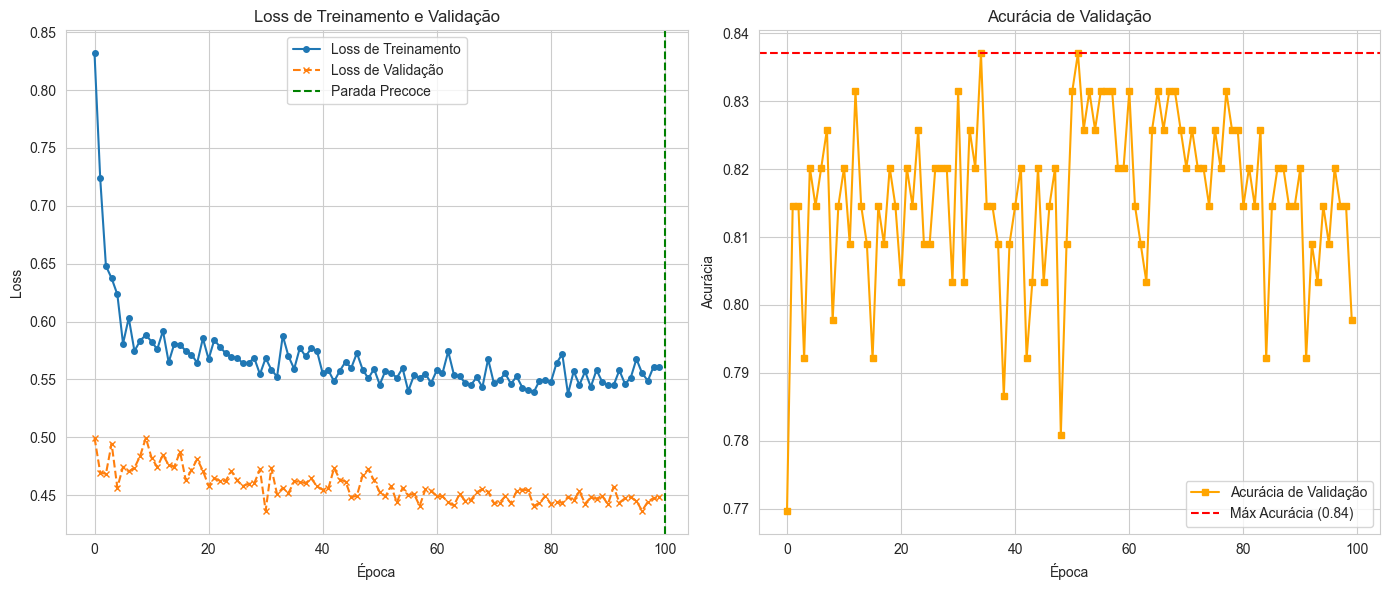

In [135]:
historico = treinar_modelo(net, train_loader, val_loader, criterion, optimizer, args['epoch_num'], args['device'])

def plot_training_results(historico):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(historico['train_loss'], label='Loss de Treinamento', linestyle='-', marker='o', markersize=4)
    plt.plot(historico['val_loss'], label='Loss de Validação', linestyle='--', marker='x', markersize=4)
    plt.axvline(len(historico['val_loss']), color='green', linestyle='--', label='Parada Precoce')
    plt.title('Loss de Treinamento e Validação')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(historico['val_accuracy'], label='Acurácia de Validação', linestyle='-', color='orange', marker='s', markersize=4)
    max_accuracy = max(historico['val_accuracy'])
    plt.axhline(max_accuracy, color='red', linestyle='--', label=f'Máx Acurácia ({max_accuracy:.2f})')
    plt.title('Acurácia de Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('treinamento_validacao.png', dpi=300)  
    plt.show()


plot_training_results(historico)

In [136]:
print(f"Resultados da última época (Época {args['epoch_num']}):")
print(f"Loss de Treino: {historico['train_loss'][-1]:.4f}")
print(f"Acurácia de Validação: {historico['val_accuracy'][-1]:.4f}")
print(f"Tempo de Treino: {historico['tempo_treino'][-1]:.2f} segundos")
print(f"Tempo de Validação: {historico['tempo_val'][-1]:.2f} segundos")

Resultados da última época (Época 100):
Loss de Treino: 0.5609
Acurácia de Validação: 0.7978
Tempo de Treino: 0.14 segundos
Tempo de Validação: 0.01 segundos


## Fazendo predições e comparando com os resultados do teste

In [137]:
def predict(model, test_loader, device):
    model.eval()  
    predicoes = []
    
    with torch.no_grad(): 
        for dados in test_loader:
            dados = dados.to(device)
            outputs = model(dados)
            preds = (outputs.squeeze() > 0.5).cpu().numpy() 
            predicoes.extend(preds)
    
    return np.array(predicoes)

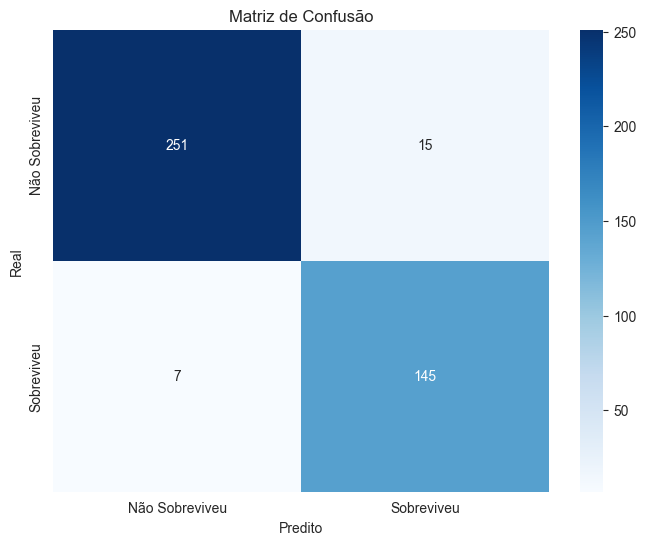


Acurácia no conjunto de teste: 0.9474

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       266
           1       0.91      0.95      0.93       152

    accuracy                           0.95       418
   macro avg       0.94      0.95      0.94       418
weighted avg       0.95      0.95      0.95       418


Exemplos de predições diferentes do baseline:
+-----+---------------+-------------+---------------------+
|     |   PassengerId |   Predicted |   Gender_Submission |
+=====+===============+=============+=====================+
|  21 |           913 |           1 |                   0 |
+-----+---------------+-------------+---------------------+
|  23 |           915 |           1 |                   0 |
+-----+---------------+-------------+---------------------+
|  32 |           924 |           0 |                   1 |
+-----+---------------+-------------+---------------------+
|  50 |           

In [138]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

gender_submission = pd.read_csv('../data/gender_submission.csv')

predicoes = predict(net, test_loader, args['device'])

resultados = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predicoes.astype(int)
})

comparacao = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Predicted': predicoes.astype(int),
    'Gender_Submission': gender_submission['Survived']
})

accuracy = accuracy_score(gender_submission['Survived'], predicoes)
conf_matrix = confusion_matrix(gender_submission['Survived'], predicoes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

print(f"\nAcurácia no conjunto de teste: {accuracy:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(gender_submission['Survived'], predicoes))

discordancias = comparacao[comparacao['Predicted'] != comparacao['Gender_Submission']]
print("\nExemplos de predições diferentes do baseline:")
print(tabulate(discordancias.head(10), headers='keys', tablefmt='grid'))

resultados.to_csv('predicoes_deep_learning.csv', index=False)

# Otimização da rede

In [181]:
import optuna
from optuna.trial import Trial
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [182]:
# 1. Classe do modelo otimizado
class ResidualConnection(nn.Module):
    def __init__(self):
        super(ResidualConnection, self).__init__()
    
    def forward(self, x):
        return x

class OptimizedTitanicModel(nn.Module):
    def __init__(self, config):
        super(OptimizedTitanicModel, self).__init__()
        
        self.n_layers = config['n_layers']
        self.residual = config['residual']
        
        # Dicionário de ativações
        activations = {
            'ReLU': nn.ReLU(),
            'LeakyReLU': nn.LeakyReLU(config['leaky_slope']),
            'ELU': nn.ELU(),
            'GELU': nn.GELU(),
            'SiLU': nn.SiLU()
        }
        self.activation = activations[config['activation']]
        
        # Dicionário de normalizações
        def get_norm_layer(size):
            if config['normalization'] == 'BatchNorm':
                return nn.BatchNorm1d(size, momentum=config['batch_norm_momentum'])
            elif config['normalization'] == 'LayerNorm':
                return nn.LayerNorm(size)
            return nn.Identity()
        
        # Dicionário de dropouts
        def get_dropout_layer(p):
            if config['dropout_type'] == 'Alpha':
                return nn.AlphaDropout(p)
            elif config['dropout_type'] == 'Spatial':
                return nn.Dropout2d(p)
            return nn.Dropout(p)
        
        # Construir camadas
        layers = []
        input_size = 7
        hidden_sizes = [config['hidden_size_1'], config['hidden_size_2'], 
                       config['hidden_size_3']]
        
        for i in range(self.n_layers):
            output_size = hidden_sizes[min(i, len(hidden_sizes)-1)]
            
            layer_block = nn.Sequential(
                nn.Linear(input_size, output_size),
                self.activation,
                get_norm_layer(output_size),
                get_dropout_layer(config['dropout'])
            )
            
            layers.append(layer_block)
            
            if self.residual and input_size == output_size:
                layers.append(ResidualConnection())  # Usando a classe própria em vez de lambda
            
            input_size = output_size
        
        layers.append(nn.Linear(input_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
        
        self._initialize_weights(config['init_type'], config['init_gain'])
    
    def _initialize_weights(self, init_type, gain):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'kaiming_normal':
                    nn.init.kaiming_normal_(m.weight, a=gain)
                elif init_type == 'kaiming_uniform':
                    nn.init.kaiming_uniform_(m.weight, a=gain)
                elif init_type == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight, gain=gain)
                elif init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight, gain=gain)
                
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.network(x)

In [183]:
def get_trial_params(trial: Trial):
    return {
        # Parâmetros existentes
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 48, 64, 80, 96, 112, 128]),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.7),
        'hidden_size_1': trial.suggest_int('hidden_size_1', 64, 512, step=64),
        'hidden_size_2': trial.suggest_int('hidden_size_2', 32, 256, step=32),
        'hidden_size_3': trial.suggest_int('hidden_size_3', 16, 128, step=16),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop']),
        'scheduler': trial.suggest_categorical('scheduler', ['CosineAnnealingLR', 'OneCycleLR', 'ReduceLROnPlateau']),
        
        # Novos parâmetros
        # Ativações
        'activation': trial.suggest_categorical('activation', 
            ['ReLU', 'LeakyReLU', 'ELU', 'GELU', 'SiLU']),
        'leaky_slope': trial.suggest_float('leaky_slope', 0.01, 0.3),  # para LeakyReLU
        
        # Normalização
        'normalization': trial.suggest_categorical('normalization',
            ['BatchNorm', 'LayerNorm', 'None']),
        'batch_norm_momentum': trial.suggest_float('batch_norm_momentum', 0.1, 0.99),
        
        # Regularização
        'dropout_type': trial.suggest_categorical('dropout_type',
            ['Standard', 'Alpha', 'Spatial']),
        'l1_lambda': trial.suggest_float('l1_lambda', 1e-6, 1e-3, log=True),
        
        # Inicialização dos pesos
        'init_type': trial.suggest_categorical('init_type',
            ['kaiming_normal', 'kaiming_uniform', 'xavier_normal', 'xavier_uniform']),
        'init_gain': trial.suggest_float('init_gain', 0.01, 2.0),
        
        # Otimizador
        'beta1': trial.suggest_float('beta1', 0.8, 0.999),  # para Adam/AdamW
        'beta2': trial.suggest_float('beta2', 0.9, 0.9999),
        'momentum': trial.suggest_float('momentum', 0.6, 0.99),  # para RMSprop
        
        # Scheduler
        'scheduler_patience': trial.suggest_int('scheduler_patience', 5, 15),
        'scheduler_factor': trial.suggest_float('scheduler_factor', 0.1, 0.5),
        
        # Arquitetura
        'n_layers': trial.suggest_int('n_layers', 3, 5),
        'residual': trial.suggest_categorical('residual', [True, False]),
        
        # Regularização avançada
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.2),
        'mixup_alpha': trial.suggest_float('mixup_alpha', 0.1, 0.8),
        'gradient_clip': trial.suggest_float('gradient_clip', 0.1, 1.0)
    }

In [184]:
# 3. Função de treinamento para um epoch
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

In [185]:
# 4. Função de validação para um epoch
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = (output > 0.5).float()
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    return val_loss / len(val_loader), correct / total

In [186]:
# 5. Função principal de treinamento
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, config, trial=None, device='cuda'):
    best_val_accuracy = 0
    patience = 20
    patience_counter = 0
    
    for epoch in range(args['epoch_num']):
        # Treinamento
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validação
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)
        
        # Atualização do scheduler
        if scheduler:
            if config['scheduler'] == 'ReduceLROnPlateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break
        
        # Reporte para Optuna (apenas se trial existir)
        if trial is not None:
            trial.report(val_accuracy, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
    
    return best_val_accuracy


In [187]:
# 6. Função objetivo para Optuna
def objective(trial: Trial):
    # Obter configuração dos hiperparâmetros
    config = get_trial_params(trial)
    
    # Criar dataloaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Criar modelo
    model = OptimizedTitanicModel(config).to(args['device'])
    
    # Configurar otimizador e scheduler
    optimizer = get_optimizer(model, config)
    scheduler = get_scheduler(optimizer, config, args['epoch_num'], len(train_loader))
    
    # Treinar modelo
    best_val_accuracy = train_model(
        model, train_loader, val_loader, optimizer, scheduler, 
        criterion, config, trial, args['device']
    )
    
    return best_val_accuracy

In [188]:
import logging
import sys
import tqdm

class TqdmCallback:
    def __init__(self, n_trials):
        self.n_trials = n_trials
        self.current_trial = 0
        self.best_value = float('-inf')
        self.best_params = None
        self._print_header()
        
        # Configurar logging para suprimir mensagens do Optuna
        optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def _print_header(self):
        print("\nIniciando otimização de hiperparâmetros")
        print("-" * 100)
    
    def _create_progress_bar(self, width=30):
        progress = int(width * self.current_trial / self.n_trials)
        return f"[{'=' * progress}{' ' * (width - progress)}]"
    
    def __call__(self, study, trial):
        self.current_trial += 1
        
        # Atualiza melhor valor
        if trial.value > self.best_value:
            self.best_value = trial.value
            self.best_params = trial.params
        
        # Criar string de progresso
        progress_bar = self._create_progress_bar()
        progress_str = (
            f"\rProgresso: {progress_bar} {self.current_trial}/{self.n_trials} | "
            f"Melhor Acc: {self.best_value:.4f} | "
            f"Trial Atual: {trial.value:.4f} | "
            f"Trial #{trial.number}"
        )
        
        # Limpa linha atual e imprime progresso
        sys.stdout.write(progress_str)
        sys.stdout.flush()
    
    def close(self):
        print("\n" + "-" * 100)  # Linha final para separar resultados

In [189]:
# 7. Execução da otimização
def run_optimization(n_trials=50):
    # Configurar logging para suprimir mensagens do Optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    study = optuna.create_study(direction='maximize')
    callback = TqdmCallback(n_trials)
    
    try:
        study.optimize(objective, n_trials=n_trials, callbacks=[callback])
    finally:
        callback.close()
    
    print("\nResultados finais da otimização:")
    print(f"Número de trials completados: {len(study.trials)}")
    print(f"Melhor acurácia encontrada: {study.best_value:.4f}")
    print("\nMelhores hiperparâmetros:")
    for param, value in study.best_params.items():
        print(f"{param}: {value}")
    
    return study

In [190]:
# 8. Visualização dos resultados
def plot_optimization_results(study):
    # Configurando o estilo do seaborn
    sns.set_style("whitegrid")
    
    # Criando figura com dois subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Histórico de Otimização
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    epochs = list(range(len(values)))
    
    sns.scatterplot(x=epochs, y=values, ax=ax1)
    sns.lineplot(x=epochs, y=values, ax=ax1)
    ax1.set_xlabel('Número do Trial')
    ax1.set_ylabel('Acurácia de Validação')
    ax1.set_title('Histórico de Otimização')
    
    # Plot 2: Importância dos Parâmetros
    importances = optuna.importance.get_param_importances(study)
    importance_df = pd.DataFrame({
        'Parâmetro': list(importances.keys()),
        'Importância': list(importances.values())
    })
    
    sns.barplot(data=importance_df, y='Parâmetro', x='Importância', ax=ax2)
    ax2.set_title('Importância dos Parâmetros')
    
    plt.tight_layout()
    plt.savefig('optimization_results_seaborn.png')  # Salvando a figura
    plt.show()

In [191]:
def train_best_model(best_params):
    # Criar modelo com os melhores parâmetros
    best_model = OptimizedTitanicModel(best_params).to(args['device'])
    
    # Criar dataloaders
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
    # Configurar otimizador e scheduler
    optimizer = get_optimizer(best_model, best_params)
    scheduler = get_scheduler(optimizer, best_params, args['epoch_num'], len(train_loader))
    
    # Treinar modelo
    best_val_accuracy = train_model(
        best_model, train_loader, val_loader, optimizer, scheduler, 
        criterion, best_params, None, args['device']
    )
    
    return best_model, best_val_accuracy

In [192]:
# Ajuste na função compare_models para usar o modelo já treinado
def compare_models(original_model, optimized_model, test_loader):
    def get_predictions(model, loader):
        model.eval()
        predictions = []
        
        with torch.no_grad():
            for data in loader:
                data = data.to(args['device'])
                output = model(data)
                pred = (output > 0.5).float()
                predictions.extend(pred.cpu().numpy())
        
        return np.array(predictions)
    
    # Carregar as predições reais do conjunto de teste (gender_submission.csv)
    gender_submission = pd.read_csv('../data/gender_submission.csv')
    true_labels = gender_submission['Survived'].values
    
    # Obter predições dos dois modelos no conjunto de teste
    original_preds = predict(original_model, test_loader, args['device'])
    optimized_preds = get_predictions(optimized_model, test_loader)
    
    # Calcular métricas no conjunto de teste
    original_acc = accuracy_score(true_labels, original_preds)
    optimized_acc = accuracy_score(true_labels, optimized_preds)
    
    # Plotar matrizes de confusão
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Matriz de confusão do modelo original
    sns.heatmap(confusion_matrix(true_labels, original_preds), 
                annot=True, fmt='d', ax=ax1, cmap='Blues',
                xticklabels=['Não Sobreviveu', 'Sobreviveu'],
                yticklabels=['Não Sobreviveu', 'Sobreviveu'])
    ax1.set_title(f'Modelo Original\nAcurácia no Teste: {original_acc:.4f}')
    ax1.set_xlabel('Predito')
    ax1.set_ylabel('Real')
    
    # Matriz de confusão do modelo otimizado
    sns.heatmap(confusion_matrix(true_labels, optimized_preds), 
                annot=True, fmt='d', ax=ax2, cmap='Blues',
                xticklabels=['Não Sobreviveu', 'Sobreviveu'],
                yticklabels=['Não Sobreviveu', 'Sobreviveu'])
    ax2.set_title(f'Modelo Otimizado\nAcurácia no Teste: {optimized_acc:.4f}')
    ax2.set_xlabel('Predito')
    ax2.set_ylabel('Real')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_comparison.png')
    plt.show()
    
    # Imprimir relatório detalhado
    print("\nResultados no conjunto de teste:")
    print(f"Acurácia do modelo original: {original_acc:.4f}")
    print(f"Acurácia do modelo otimizado: {optimized_acc:.4f}")
    print(f"Melhoria absoluta: {(optimized_acc - original_acc):.4f}")
    print(f"Melhoria relativa: {((optimized_acc - original_acc)/original_acc)*100:.2f}%")
    
    print("\nRelatório de classificação do modelo original:")
    print(classification_report(true_labels, original_preds))
    
    print("\nRelatório de classificação do modelo otimizado:")
    print(classification_report(true_labels, optimized_preds))


Iniciando otimização de hiperparâmetros
----------------------------------------------------------------------------------------------------
Progresso: [==============================] 1000/1000 | Melhor Acc: 0.8652 | Trial Atual: 0.7753 | Trial #999
----------------------------------------------------------------------------------------------------

Resultados finais da otimização:
Número de trials completados: 1000
Melhor acurácia encontrada: 0.8652

Melhores hiperparâmetros:
batch_size: 80
lr: 0.0022191697819045745
weight_decay: 0.001093477106240638
dropout: 0.22256988237756015
hidden_size_1: 448
hidden_size_2: 64
hidden_size_3: 96
optimizer: AdamW
scheduler: CosineAnnealingLR
activation: LeakyReLU
leaky_slope: 0.21729930981458573
normalization: BatchNorm
batch_norm_momentum: 0.7145550657876428
dropout_type: Spatial
l1_lambda: 0.0002416556569346055
init_type: xavier_uniform
init_gain: 1.8168370801329825
beta1: 0.9439458560715089
beta2: 0.9284701148256337
momentum: 0.919119821231915

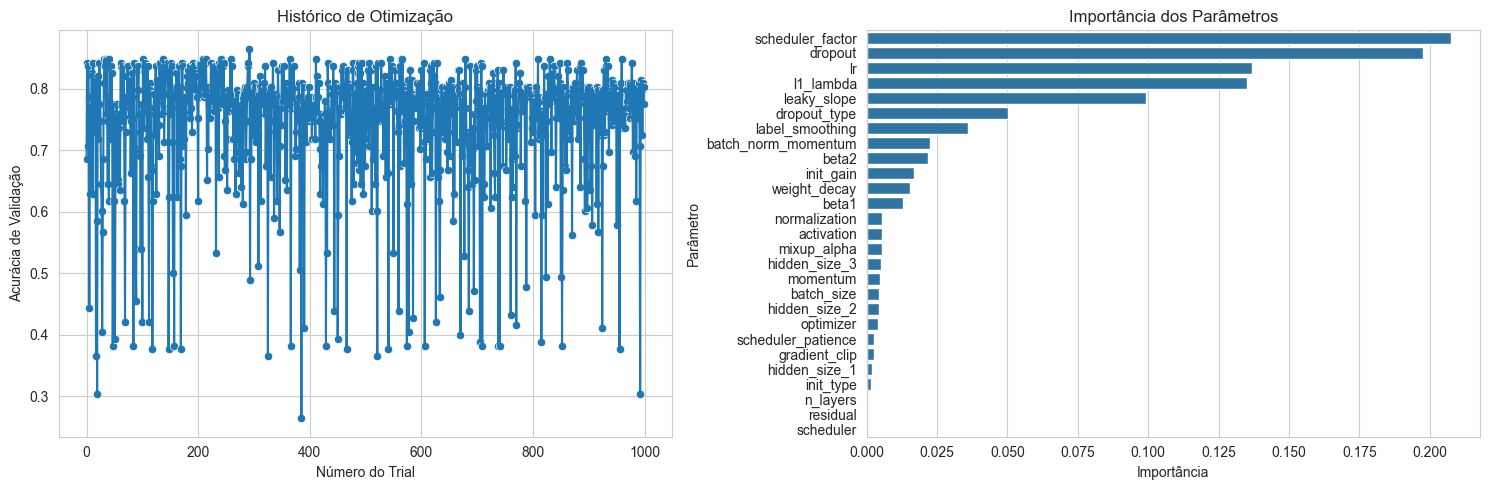

c:\Users\breno\OneDrive\Documentos\GitHub\facprj-titanic\venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
c:\Users\breno\OneDrive\Documentos\GitHub\facprj-titanic\venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).


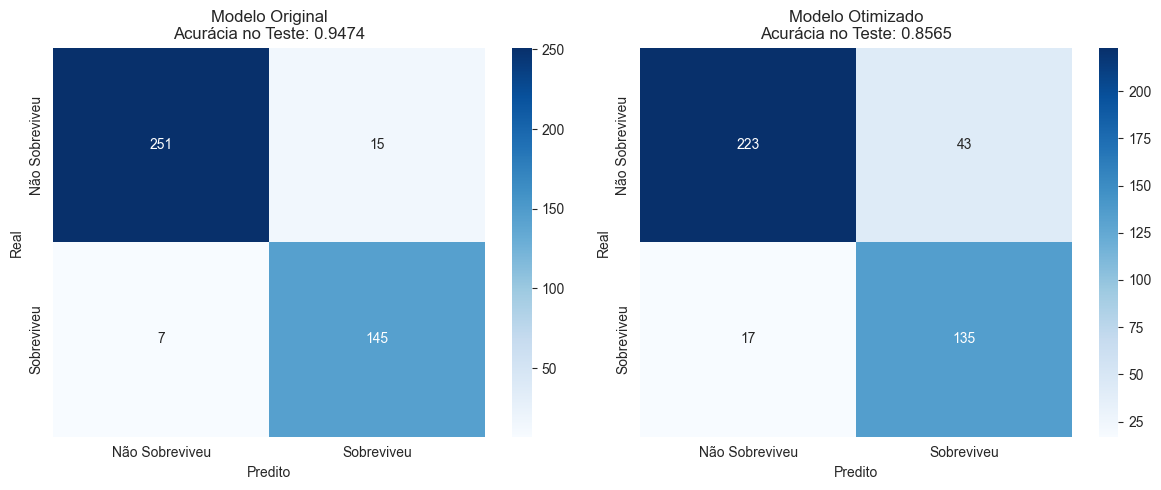


Resultados no conjunto de teste:
Acurácia do modelo original: 0.9474
Acurácia do modelo otimizado: 0.8565
Melhoria absoluta: -0.0909
Melhoria relativa: -9.60%

Relatório de classificação do modelo original:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       266
           1       0.91      0.95      0.93       152

    accuracy                           0.95       418
   macro avg       0.94      0.95      0.94       418
weighted avg       0.95      0.95      0.95       418


Relatório de classificação do modelo otimizado:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       266
           1       0.76      0.89      0.82       152

    accuracy                           0.86       418
   macro avg       0.84      0.86      0.85       418
weighted avg       0.87      0.86      0.86       418



In [193]:
# Criar o test_loader
test_loader = DataLoader(dataset_test, batch_size=args['batch_size'], shuffle=False)

# Na execução principal
if __name__ == "__main__":
    # Executar otimização
    study = run_optimization(n_trials=1000)
    plot_optimization_results(study)
    
    # Treinar apenas o modelo otimizado
    best_model, best_accuracy = train_best_model(study.best_params)
    
    # Comparar com o modelo original (já treinado)
    compare_models(net, best_model, test_loader)
    
    # Salvar o modelo otimizado
    torch.save(best_model.state_dict(), 'best_model.pth')